Processing patient folder: IWP5
Processing folder: /Users/ajahedi/OneDrive - Inside MD Anderson/CODEX Resources & Papers/computational files/qc/Stitching/Raw_tissue plots/IWP5/IWP5Reg01/no


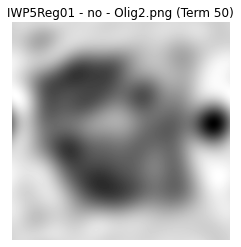

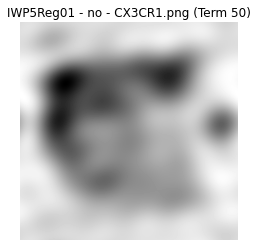

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re

def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)

def calculate_2dift(input):
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift.real

def calculate_distance_from_centre(coords, centre):
    return np.sqrt((coords[0] - centre) ** 2 + (coords[1] - centre) ** 2)

def find_symmetric_coordinates(coords, centre):
    return (centre + (centre - coords[0]), centre + (centre - coords[1]))

base_path = "/Users/ajahedi/OneDrive - Inside MD Anderson/CODEX Resources & Papers/computational files/qc/Stitching/Raw_tissue plots"
patient_folders = ["IWP5","IWP6","IWP7","IWP8","IWP9","IWP10","IWP11", "IWR5","IWR6", "IWR7","IWR8","IWR9","IWR10", "IWR11"]  # specify patient folders
max_regions = 10

for patient_folder in patient_folders:
    print(f"Processing patient folder: {patient_folder}")
    for region_number in range(1, max_regions + 1):
        for folder in ['no', 'high']:
            folder_path = os.path.join(base_path, patient_folder, f"{patient_folder}Reg{region_number:02}", folder)

            if not os.path.exists(folder_path):
                print(f"Folder does not exist: {folder_path}")
                continue
            
            print(f"Processing folder: {folder_path}")

            # Extract the desired folder name from the path
            folder_name = os.path.basename(os.path.dirname(folder_path))
            current_folder_name = os.path.basename(folder_path.rstrip('/'))
            match = re.search(r'IWP\d+Reg\d+', folder_path)
            if match:
                plot_title_prefix = match.group()
            else:
                plot_title_prefix = folder_name

            # List all files in the directory
            all_files = os.listdir(folder_path)

            # Filter out only PNG files
            png_files = [f for f in all_files if f.endswith('.png')]
            average_intensities = []
            file_names = []

            for image_filename in png_files:
                full_image_path = os.path.join(folder_path, image_filename)
                image = plt.imread(full_image_path)
                image = image[:, :, :3].mean(axis=2)  # Convert to grayscale

                # Fourier transform
                ft = calculate_2dft(image)
                array_size = len(image)
                centre = int((array_size - 1) / 2)
                coords_left_half = ((x, y) for x in range(array_size) for y in range(centre+1))
                coords_left_half = sorted(coords_left_half, key=lambda x: calculate_distance_from_centre(x, centre))

                # Reconstruct image up to term 50
                rec_image = np.zeros(image.shape)
                individual_grating = np.zeros(image.shape, dtype="complex")
                for idx, coords in enumerate(coords_left_half, start=1):
                    if idx > 50:
                        break
                    symm_coords = find_symmetric_coordinates(coords, centre)
                    individual_grating[coords] = ft[coords]
                    individual_grating[symm_coords] = ft[symm_coords]
                    rec_grating = calculate_2dift(individual_grating)
                    rec_image += rec_grating
                    individual_grating[coords] = 0
                    individual_grating[symm_coords] = 0

                # Display the reconstructed image after the 50th term with the title
                plt.figure()
                plt.imshow(rec_image, cmap="gray")
                plt.title(f"{plot_title_prefix} - {current_folder_name} - {image_filename} (Term 50)")
                plt.axis("off")
                plt.show()

                # Accumulate average intensity
                avg_intensity = np.mean(rec_image)
                average_intensities.append(avg_intensity)
                file_names.append(image_filename)

            # Plot average intensities for all markers
            plt.figure()
            plt.bar(file_names, average_intensities)
            plt.ylabel('Average Intensity')
            plt.xlabel('File Name')
            plt.xticks(rotation=90)
            plt.tight_layout()
            plt.title(f'Average Intensities for All Markers in {current_folder_name}')
            plt.show()

print("Completed processing.")
